In [ ]:
import yfinance as yf
import random
from typing import Tuple


class Money:
    """This class is to compare lump-sum investment vs. dollar cost averaging."""

    def __init__(
        self,
        ticker: str = "^GSPC",
        num_trading_days: int = 252,
        seed: int = 42,
    ) -> None:
        """Init the Money class.

        Args
        ----
        ticker: ticcker symbol (e.g., ^GSPC is SP500)
        num_trading_days: The NYSE and NASDAQ average about 252 trading days a year.
            This is from 365.25 (days on average per year) * 5/7 (proportion work days
            per week) - 6 (weekday holidays) - 4*5/7 (fixed date holidays) = 252.03
            ≈ 252.

        """
        self.seed = seed
        random.seed(seed)

        self.ticker = ticker
        self.data = yf.download(self.ticker, interval="1d")
        self.data.Close.plot(
            title=f"ticker symbol: {self.ticker}", xlabel="year", ylabel="price"
        )
        self.data_array = self.data.Close.array.to_numpy()
        self.num_trading_days = num_trading_days

    def get_random_starting_date(self, num_years_investment: int) -> int:
        """Get a random investment starting date.

        Args
        ----
        num_years_investment: number of years of investment to consider.

        Returns
        -------
        starting date

        """
        return random.randint(
            0,
            len(self.data_array) - num_years_investment * self.num_trading_days - 1,
        )

    def get_roi_lump(self, start_date: int, num_years_investment: int) -> float:
        """Return on investment with lump-sum.

        Args
        ----
        start_date: starting date
        num_years_investment: number of years of investment to consider.

        Returns
        -------
        ROI with lump-sum

        """
        end = self.data_array[
            start_date + (num_years_investment * self.num_trading_days)
        ]
        start = self.data_array[start_date]

        invested = 1
        final = invested * (end / start)

        roi_lump = (final - invested) / invested

        return roi_lump

    def get_roi_dca(
        self,
        start_date: int,
        period_trading_days: int,
        num_years_investment: int,
        inflation: float,
    ) -> float:
        """Return on investment with dollar cost averaging.

        Args
        ----
        start_date: starting date
        period_trading_days: number of trading days between installments.
        num_years_investment: number of years of investment to consider.
        inflation: YoY inflation. This number should be between 0 and 1.

        Returns
        -------
        ROI with dollar cost averaging

        """
        self.num_installments = (
            self.num_trading_days * num_years_investment // period_trading_days
        )
        end = self.data_array[
            start_date + (num_years_investment * self.num_trading_days)
        ]
        start = self.data_array[start_date]

        invested = 1
        first_installment = invested / self.num_installments
        final = 0
        for i in range(self.num_installments):
            final += (
                (end / (start + (i * period_trading_days)))
                * first_installment
                * ((1 + inflation) ** i)
            )
        return (final - invested) / invested

    def get_roi(
        self, period_trading_days: int, num_years_investment: int, inflation: float
    ) -> Tuple[float, float]:
        """Get lump-sum and dollar cost averaging ROIs.

        Args
        ----
        period_trading_days: number of trading days between installments.
        num_years_investment: number of years of investment to consider.
        inflation: YoY inflation. This number should be between 0 and 1.

        Returns
        -------
        roi_lump, roi_dca

        """
        start_date = self.get_random_starting_date(num_years_investment)
        roi_lump = self.get_roi_lump(start_date, num_years_investment)
        roi_dca = self.get_roi_dca(
            start_date, period_trading_days, num_years_investment, inflation
        )

        return roi_lump, roi_dca

    def run(
        self,
        period_trading_days: int,
        num_years_investment: int,
        inflation: float,
        num_trials: int = 10000,
    ) -> float:
        """Run the comparision.

        Args
        ----
        period_trading_days: number of trading days between installments.
        num_years_investment: number of years of investment to consider.
        inflation: YoY inflation. This number should be between 0 and 1.
        num_trials: number of trials. This is done since we pick a random date to start
            investment.

        Returns
        -------
        chance of dca wins over lump wins.

        """
        bools = []
        for _ in range(num_trials):
            roi_lump, roi_dca = self.get_roi(
                period_trading_days, num_years_investment, inflation
            )
            if roi_lump < roi_dca:
                bools.append(True)
            else:
                bools.append(False)

        dca_chance = sum(bools) / num_trials

        print(
            f"Chance of winning by investing every {period_trading_days} trading days, "
            f"for {num_years_investment} year(s) when inflation is fixed at {inflation}, "
            f"compared to investing at once: {dca_chance}"
        )
        return dca_chance

In [ ]:
money = Money(ticker="^GSPC")

In [ ]:
inflation = 0.04
results = {}
for num_years_investment in [1, 2, 4, 8, 16, 32]:
    results[num_years_investment] = {}
    for period_trading_days in [2, 4, 8, 16, 32, 64, 128, 256, 512]:
        try:
            dca_chance = money.run(
                period_trading_days=period_trading_days,
                num_years_investment=num_years_investment,
                inflation=inflation,
            )
            results[num_years_investment][period_trading_days] = dca_chance
        except Exception as e:
            print(e)
    print()

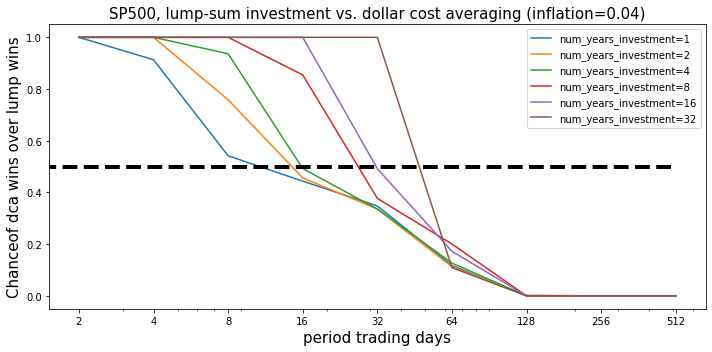

In [5]:
import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots(figsize=(10, 5))
for key, val in results.items():
    # plt.plot(list(val.keys()), list(val.values()))
    # plt.xscale("log")
    ax.plot(list(val.keys()), list(val.values()))

ax.set_xscale("log")
ax.set_xticks(list(val.keys()))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.hlines(y=0.5, xmin=0, xmax=512, linewidth=4, color="k", linestyles="--")
ax.legend([f"num_years_investment={foo}" for foo in list(results.keys())])
ax.set_title(
    f"SP500, lump-sum investment vs. dollar cost averaging (inflation={inflation})",
    fontsize=15,
)
ax.set_xlabel("period trading days", fontsize=15)
ax.set_ylabel("Chanceof dca wins over lump wins", fontsize=15)
fig.tight_layout()
plt.savefig("sp500.svg")